Epoch 1/10
449/449 [==============================] - 44s 84ms/step - loss: 0.1758 - accuracy: 0.9249 - val_loss: 0.1087 - val_accuracy: 0.9574
Epoch 2/10
449/449 [==============================] - 38s 85ms/step - loss: 0.0533 - accuracy: 0.9819 - val_loss: 0.1157 - val_accuracy: 0.9585
Epoch 3/10
449/449 [==============================] - 35s 78ms/step - loss: 0.0198 - accuracy: 0.9943 - val_loss: 0.1497 - val_accuracy: 0.9589
Epoch 3: early stopping
253/253 [==============================] - 2s 9ms/step - loss: 0.1552 - accuracy: 0.9608
Test Loss: 0.1552283614873886
Test Accuracy: 0.9607770442962646
253/253 [==============================] - 5s 15ms/step


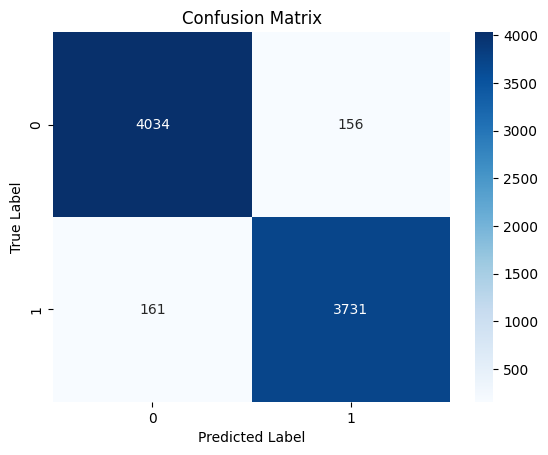

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the ISOT dataset
true_data = pd.read_csv("/content/drive/MyDrive/True.csv")
fake_data = pd.read_csv("/content/drive/MyDrive/Fake.csv")

# Add labels to the data
true_data['label'] = 1
fake_data['label'] = 0

# Preprocessing
data = pd.concat([true_data, fake_data], axis=0)
data['text'] = data['title'] + ' ' + data['text']
data['text'] = data['text'].apply(lambda x: re.sub(r'\d+', '', x))  # Remove numbers
data['text'] = data['text'].apply(lambda x: x.lower())  # Convert to lowercase

# Split data into train, validation, and test sets
train_data, test_val_data = train_test_split(data, test_size=0.36, random_state=42)
val_data, test_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

# Tokenization and word embedding
max_features = 10000  # Maximum number of words to keep based on word frequency
max_len = 42  # Maximum length of each input sequence

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data['text'])

train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_val = pad_sequences(val_sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')

# Encode the labels
le = LabelEncoder()
y_train = le.fit_transform(train_data['label'])
y_val = le.transform(val_data['label'])
y_test = le.transform(test_data['label'])

# Model architecture
embedding_dim = 100

model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model training
epochs = 10
batch_size = 64

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_data=(X_val, y_val), callbacks=[early_stop])

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Confusion matrix visualization
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()